In [ ]:
# Matteo's version of the plotting
reload(do)
dt=1e-2
import matplotlib.animation as animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
line, = ax.plot(system.grid, do.eval_one_body_density(system, nparticles, C0).real)
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
ani = animation.FuncAnimation(fig, do.animation, fargs=(line, system, dt, t_max, C0, omega, epsilon0, nparticles, integrator), interval=200, blit=True, save_count=1000)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [68]:
%reset

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do2
from importlib import reload
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem

In [71]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

Converged


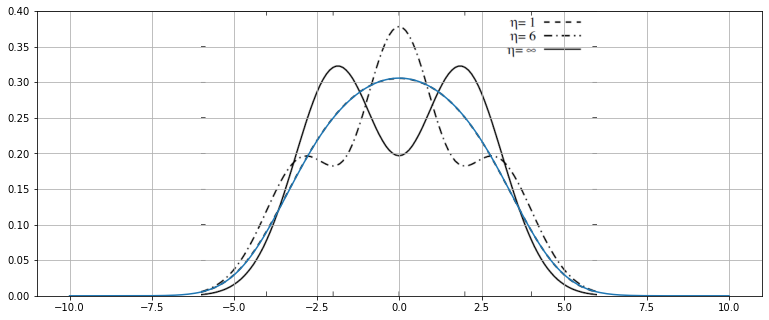

In [81]:
reload(do2)
ghf = do2.GHF()
epsilon, C0, energy1 = ghf.solve_TIHF(tolerance=1e-12, max_iter=100, print_ON=True, energy_per_step_ON=True)
onebody = ghf.eval_one_body_density(C0, plot_ON=True)

In [74]:
reload(do2)
rhf = do2.RHF()
epsilon, C0, energy2 = rhf.solve_TIHF(tolerance=1e-15, max_iter=60, print_ON=True, energy_per_step_ON=True)
#onebody = rhf.eval_one_body_density(C0, plot_ON=True)

TypeError: eval_one_body_density() missing 1 required positional argument: 'plot_ON'

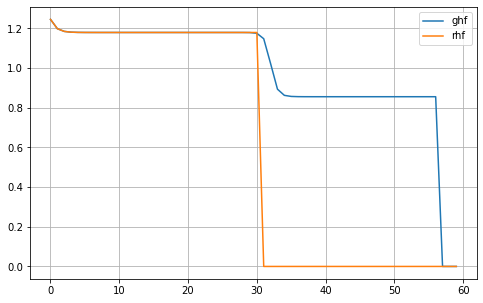

In [62]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(energy1)), energy1.real, label='ghf')
plt.plot(np.arange(len(energy1)), energy2.real, label='rhf')
plt.grid()
plt.legend()